We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add EllipticEulerianDiffusionBarriers folder to current working path
sys.path.append(parent_directory+"/demos/DiffusionBarriers/EllipticEulerianDiffusionBarriers")

# Overview

In the following notebook we extract elliptic Eulerian diffusion barriers from a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'.
2. Define computational parameters and variables.
3. Define spatio-temporal domain.
4. Interpolate velocity from the (discrete) gridded data.
5. Elliptic Eulerian diffusion barriers:

    Compute gradient of velocity field $ \mathbf{\nabla v}(\mathbf{x}. t) $ over meshgrid using an auxiliary meshgrid. 

    Compute rate of strain: 
    
    \begin{equation} 
    \mathbf{S}(\mathbf{x}, t) = \begin{pmatrix} S_{11} & S_{12} \\ S_{11} & S_{12} \end{pmatrix} = \dfrac{1}{2}(\mathbf{v}(\mathbf{x}, t)+\mathbf{v}(\mathbf{x}, t)^T) \tag{1} 
    \end{equation}

    Uniform Eulerian diffusion barriers satisfy
    
    \begin{equation}
    \langle \mathbf{x}', (2\mathbf{S}(\mathbf{x}, t)- \mathcal{T}_0 \mathbf{I})
    \mathbf{x}') = 0 \tag{2}
    \end{equation}
    
    Elliptic Eulerian diffusion barriers are closed null geodesics of the one-parameter family of Lorentzian
    metrics:
    
    \begin{equation}
        \mathbf{A}_{\mathcal{T}_0}(\mathbf{x}) = 2\mathbf{S}(\mathbf{x}, t)-
    \mathcal{T}_0\mathbf{I} \tag{3},
    \end{equation} 
    
    on the spatial domain satisfying $ \lambda_1 \leq \mathcal{T}_0 \leq \lambda_2 $, where $ \lambda_1, \lambda_2 $ are respectively the minimum and maximum eigenvalues of $ 2\mathbf{S}(\mathbf{x}, t) $.
    
    Closed null geodesics are closed curves of the system of ODE:
    
    \begin{align}
    \dfrac{d \mathbf{x}}{ds} &= \mathbf{e}_{\phi}(s) = \begin{pmatrix} \cos(\phi(s)) \\ \sin(\phi(s)) \end{pmatrix} \tag{4} \\
    \dfrac{d \phi}{ds} &= - \dfrac{\langle \mathbf{e}_{\phi}(s), (\nabla_x A_{\mathcal{T}_0}(\mathbf{x}) \mathbf{e}_{\phi}(s)) \mathbf{e}_{\phi}(s) \rangle}{2 \langle \mathbf{e}_{\phi}, R^T A_{\mathcal{T}_0}(\mathbf{x}) \mathbf{e}_{\phi} (s)\rangle} , \label{eq: RHS} \tag{5}
    \end{align} where $ R = \begin{pmatrix} 0 && -1 \\ 1 && 0\end{pmatrix} $.
    
    The term $ \dfrac{d \phi}{ds} $ depends both on $ \mathbf{x} $ and on $ \phi $ but not on $ \lambda $ and can be evaluated through interpolation over the spatial meshgrid (X, Y) as well as over $ \phi \in [0, 2\pi] $.  
    
    The set of initial conditions is given by:
    \begin{equation}
    (\mathbf{x}_0, \phi_0)_{\mathcal{T}_0} = \lbrace (\mathbf{x}(\mathcal{T}_0, \phi_0 = 0), 0) \in V: 2S^{11}(\mathbf{x}, t) - \mathcal{T}_0 = 0 \rbrace \tag{6}
    \end{equation}
    
    Furthermore the domain of existence of the ODE is restricted to points $ \mathbf{x}, \phi $ where:
    
    \begin{equation}
    \sin(2\phi)[S^{22}(\mathbf{x})-S^{11}(\mathbf{x})]+2\cos(2\phi)S^{12}(\mathbf{x}) \neq 0 \tag{7}
    \end{equation}
    
    In order to evaluate the RHS of equation \ref{eq: RHS}, we need to interpolate the rate of strain tensor over the whole domain.

6. References

# Import data

We start by importing the AVISO-data from the file 'AVISO.mat' stored in the folder 'data/AVISO'.

In [2]:
# import scipy
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# number of cores to be used for parallel computing
Ncores = 6

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## meshgrid
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which we consider the dynamical system.

In [4]:
# Time
t_OECS = 0

assert time_data[0,0] <= t_OECS <= time_data[0,-1], "t_OECS must be between "+f'{time_data[0]} and {time_data[-1]}'

# store time in array
time = np.array([t_OECS])

# domain boundary (in degrees)
xmin = -3.5
xmax = 1
ymin = -32
ymax = -24

# make sure that domain is part of the data domain.
assert np.min(X) <= xmin <= np.max(X), " xmin must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(X) <= xmax <= np.max(X), " xmax must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(Y) <= ymin <= np.max(Y), " ymin must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(Y) <= ymax <= np.max(Y), " ymax must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(time_data) <= t_OECS <= np.max(time_data), " t_OECS must be between "+f'{np.min(time_data)} and {np.max(time_data)}'

# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Ny = X_domain.shape[0]
Nx = X_domain.shape[1]

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # [1/100, 1/5]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy]

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

  0%|          | 0/92 [00:00<?, ?it/s]

# Elliptic Eulerian diffusion barriers

## Compute rate of strain tensor

The rate of strain tensor $ S(\mathbf{x}_0, t) $ at time $ t $ is computed by iterating over meshgrid. The rate of strain tensor at point $ \mathbf{x}_0 $ at time $ t $ is computed from the gradient of the velocity field by using an auxiliary meshgrid.

In [6]:
# Import package for parallel computing
from joblib import delayed, Parallel

# Import function to compute gradient of velocity
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# split x0, y0 into N (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def parallel_S(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])
        
    # compute gradient of velocity field
    grad_vel = gradient_velocity(t_OECS, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, delta, aux_grid) # (2,2,Nx*Ny)
    
    # compute rate of strain tensor
    S = .5*(grad_vel+grad_vel.transpose(1,0,2))

    return S

In [7]:
# vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_S)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# Extract rate of strain tensor from results of parallel computation
S = results[0]

for i in range(1,len(results)):
    
    S = np.append(S, results[i], axis = 2)
    
# reshape array from vectorized form to structured meshgrid
S = S.reshape((2, 2, X_domain.shape[0], X_domain.shape[1]))

### Note that this step here is optional
# In order to suppress numerical noise arising from the computations of derivatives of the rate of strain tensor,
# we can apply a spatial average filter on the rate of strain tensor

# kernel_size of spatial average filter
kernel_size = 3

def filter_rateofstrain(C):
    
    C_filter = C.copy()
    
    for i in range(C.shape[2]):
        for ii in range(C.shape[3]):
            kernel_size_low_y = max(i-kernel_size, 0)
            kernel_size_up_y = min(i+kernel_size+1, Ny)
            kernel_size_low_x = max(ii-kernel_size, 0)
            kernel_size_up_x = min(ii+kernel_size+1, Nx)
            if len(C[0,0,kernel_size_low_y:kernel_size_up_y, kernel_size_low_x:kernel_size_up_x].ravel()) > 0:
                C_filter[0,0,i,ii] = np.nanmean(C[0,0,kernel_size_low_y:kernel_size_up_y, kernel_size_low_x:kernel_size_up_x].ravel())
                C_filter[0,1,i,ii] = np.nanmean(C[0,1,kernel_size_low_y:kernel_size_up_y, kernel_size_low_x:kernel_size_up_x].ravel())
                C_filter[1,0,i,ii] = C[0,1,i,ii]
                C_filter[1,1,i,ii] = np.nanmean(C[1,1,kernel_size_low_y:kernel_size_up_y, kernel_size_low_x:kernel_size_up_x].ravel())
    return C_filter
            
S = filter_rateofstrain(S.copy())

## Interpolate rate of strain tensor

In [8]:
# Import (cubic) RectBivariateSpline from scipy
from scipy.interpolate import RectBivariateSpline as RBS
        
# Compute gradients of elements of rate of strain tensor
S11 = S[0,0,:,:].copy()
S12 = S[0,1,:,:].copy()
S22 = S[1,1,:,:].copy()
    
# Interpolate elements of rate of strain tensor (per default: linear)
interp_S11 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(S11, nan = 0.0), kx = 3, ky = 3)
interp_S12 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(S12, nan = 0.0), kx = 3, ky = 3)
interp_S22 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(S22, nan = 0.0), kx = 3, ky = 3)

# Initialize arrays
S11x = np.zeros((S11.shape[0], S11.shape[1]))*np.nan
S11y = np.zeros((S11.shape[0], S11.shape[1]))*np.nan
S12x = np.zeros((S11.shape[0], S11.shape[1]))*np.nan
S12y = np.zeros((S11.shape[0], S11.shape[1]))*np.nan
S22x = np.zeros((S11.shape[0], S11.shape[1]))*np.nan
S22y = np.zeros((S11.shape[0], S11.shape[1]))*np.nan
    
# Define auxilary meshgrid
rho_x = aux_grid[0]/2
rho_y = aux_grid[1]/2
        
#iterate over meshgrid
for i in range(X_domain.shape[0]):
        
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute derivatives using auxiliary grid and finite-differencing
        S11x[i, j] = (interp_S11(x[1], x[0]+rho_x)[0][0]-interp_S11(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S11y[i, j] = (interp_S11(x[1]+rho_y, x[0])[0][0]-interp_S11(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        S12x[i, j] = (interp_S12(x[1], x[0]+rho_x)[0][0]-interp_S12(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S12y[i, j] = (interp_S12(x[1]+rho_y, x[0])[0][0]-interp_S12(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
            
        S22x[i, j] = (interp_S22(x[1], x[0]+rho_x)[0][0]-interp_S22(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S22y[i, j] = (interp_S22(x[1]+rho_y, x[0])[0][0]-interp_S22(x[1]-rho_y, x[0])[0][0])/(2*rho_y)

## Interpolate $ \dot{\phi}(x, y, \phi)$ 

In [9]:
# import function to compute interpolant for phi_prime
from ipynb.fs.defs.phi_prime import _phi_prime

# Interpolant phi_phrime
interp_phi_prime = _phi_prime(X_domain, Y_domain, S11, S12, S22, S11x, S11y, S12x, S12y, S22x, S22y)[0]

## Compute elliptic Eulerian diffusion barriers

In [10]:
# Import function to extract closed null geodesics
from ipynb.fs.defs.closed_null_geodesics import closed_null_geodesics

# define T0 range
T0_min = -0.01
T0_max = 0.01
n_T0 = 3*Ncores
T0_range = np.linspace(T0_min, T0_max, n_T0)

# threshold distance between starting and return point of trajectory
d_threshold = dx/4

# compute elliptic EDB
def compute_elliptic_EDB(T0):
    
    # Define list storing x, y coordinates of elliptic EDB
    x_elliptic, y_elliptic = [], []
    
    # Find all closed null geodesics
    closed_NG, init_T0 = closed_null_geodesics(X_domain, Y_domain, T0, interp_phi_prime, d_threshold, S11, iteration_length = 12, n_iterations = 4000, verbose = True)
    
    x_elliptic, y_elliptic = [], []
    # Iterate over all geodesics
    for NG in closed_NG:
        
        if np.sum(NG[0]) is not None:
            
            x = NG[0]
            y = NG[1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            
            x_elliptic.append(x)
            y_elliptic.append(y)
        
    return [x_elliptic, y_elliptic, init_T0]
        
# compute elliptic EDB with parallel computing
Elliptic_EDB = Parallel(n_jobs=Ncores, verbose = 0)(delayed(compute_elliptic_EDB)(i) for i in T0_range)

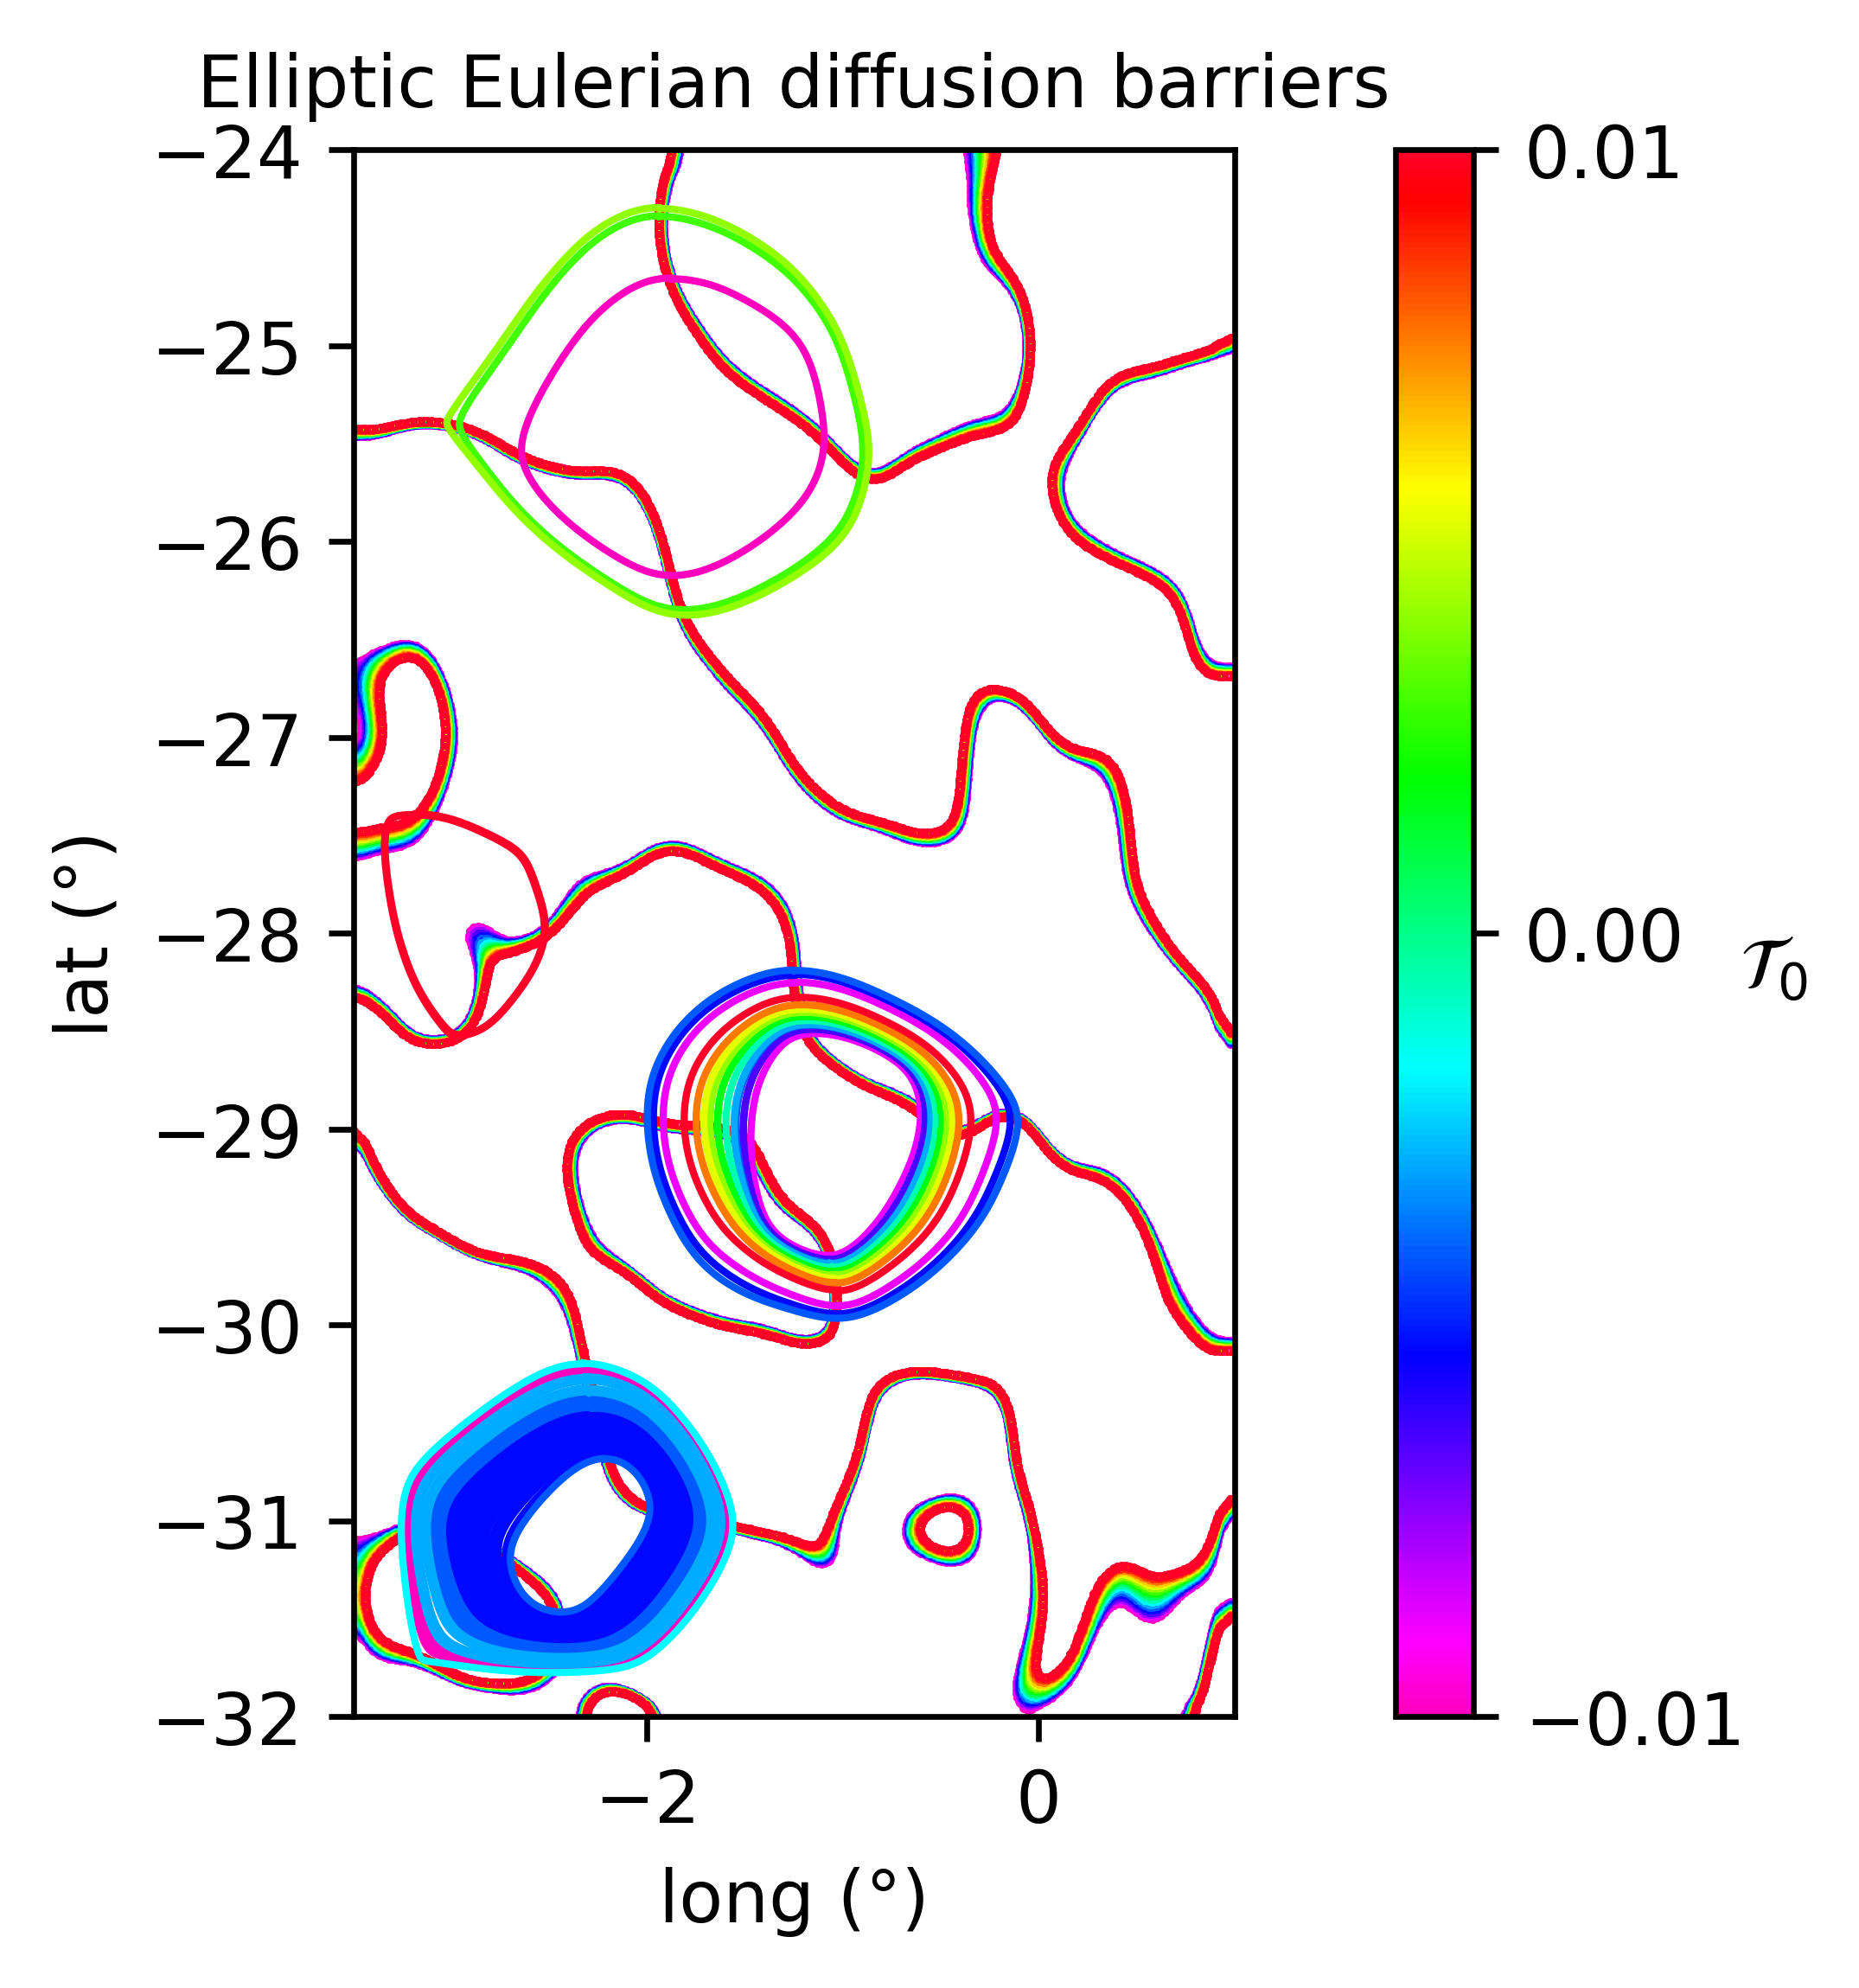

In [11]:
############################################ PLOT RESULTS ############################################
# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=T0_range.min(), vmax=T0_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# Iterate over all elliptic EDB and plot
for i in range(len(Elliptic_EDB)):
    
    # Plot initial conditions
    ax.scatter(Elliptic_EDB[i][2][0], Elliptic_EDB[i][2][1], color=cmap.to_rgba(T0_range[i]), s = 0.1)
    
    # Plot elliptic EDB
    if Elliptic_EDB[i][0] is not None:
        for j in range(len(Elliptic_EDB[i][0])):
            if Elliptic_EDB[i][0][j] is not None:
                ax.plot(Elliptic_EDB[i][0][j], Elliptic_EDB[i][1][j], c=cmap.to_rgba(T0_range[i]), linewidth = 1)

# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[T0_range.min(), 0, T0_range.max()])
cbar.ax.set_ylabel(r'$ \mathcal{T}_0 $', rotation = 0, fontsize = 10)

ax.set_aspect('equal')

# Title
ax.set_title("Elliptic Eulerian diffusion barriers", fontsize = 10)
plt.show();

The colored (closed) curves indicate elliptic Eulerian diffusion barriers with constant transport density $ \mathcal{T}_0 $. The colored dots indicate the initial conditions depending on $ \mathcal{T}_0 $.

# References

[1] Haller, G., Karrasch, D., & Kogelbauer, F. (2018). Material barriers to diffusive and stochastic transport. Proceedings of the National Academy of Sciences, 115(37), 9074-9079.

[2] Serra, M., & Haller, G. (2017). Efficient computation of null geodesics with applications to coherent vortex detection. Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences, 473(2199).

[3] Notebook 8.2. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.

[4] [YouTube Tutorial](https://youtu.be/gyDxsiqKezk)